In [ ]:
import tensorflow as tf 
import os 
import numpy as np 
from google.colab import drive 

SEED= 10714338
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/

drive  sample_data


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#data augmentation 

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(            
  width_shift_range = 0.2, 
  height_shift_range = 0.2,
  vertical_flip=True,shear_range = 0.2,
  fill_mode='constant',
  cval=0,
  rescale=1/255.)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255.)

valid_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen= ImageDataGenerator(rescale= 1/255.)


In [ ]:

#now I need to get the test images and associate them to the label contained in the json file 
import pandas as pd
import json
import sklearn


json_path=os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) #shuffling before splitting in validation and training 

training_df= train_df_shuffled[614:]
validation_df= train_df_shuffled[:614]

print(validation_df,training_df)

       filename class
3600  13561.jpg     1
1124  11420.jpg     0
1744  12331.jpg     0
3986  13167.jpg     2
1042  16432.jpg     0
...         ...   ...
3081  10205.jpg     1
3553  17796.jpg     1
3732  18032.jpg     1
230   16317.jpg     0
2968  11319.jpg     1

[614 rows x 2 columns]        filename class
1864  12020.jpg     0
3028  12530.jpg     1
1909  10516.jpg     1
4312  15427.jpg     2
2674  15230.jpg     1
...         ...   ...
4168  14596.jpg     2
485   10128.jpg     0
5105  16347.jpg     2
2245  15046.jpg     1
5008  14156.jpg     2

[5000 rows x 2 columns]


In [ ]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','training')


bs = 10

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(256, 256),
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(256, 256),
class_mode="categorical",
)

Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [ ]:
num_classes=3
img_h=256
img_w=256


train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

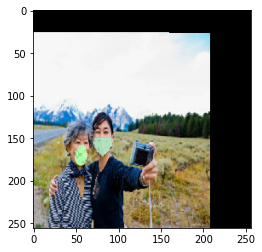

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

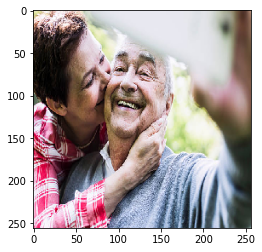

In [ ]:
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [ ]:
#lets create the model 
  
start_f = 40 # starting number of features  to be increased as we go deeper in the network  
depth = 6 #depth of my feature extractor

model=tf.keras.Sequential()

for i in range(depth):  
  if i== 0:  
     input_shape=[img_h,img_w,3]
  else:
    input_shape=[None]

  model.add(tf.keras.layers.Conv2D(filters=start_f,       #first layer is convolutional 
                                  kernel_size=(3,3),
                                  strides=(1,1),        #kernel shifted of one postion at time
                                  padding='same',
                                  input_shape=input_shape))
    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU()) #activation layer 
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #maxpooling 
  start_f=start_f*2
    


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 40)      1120      
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 40)      160       
_________________________________________________________________
re_lu_21 (ReLU)              (None, 256, 256, 40)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 40)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 80)      28880     
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 80)      320       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 128, 128, 80)     

In [ ]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= 1e-4

optimizer= tf.keras.optimizers.Adam(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics )

In [ ]:
#lets do early stopping callback 

callbacks=[]

es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5) 
callbacks.append(es_callback)


model.fit(x=train_dataset, 
          epochs=25,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Epoch 1/25
500/500 [==============================] - 132s 264ms/step - loss: 1.3227 - accuracy: 0.3714 - val_loss: 1.0753 - val_accuracy: 0.4283
Epoch 2/25
500/500 [==============================] - 129s 259ms/step - loss: 1.0949 - accuracy: 0.3956 - val_loss: 1.0808 - val_accuracy: 0.4169
Epoch 3/25
500/500 [==============================] - 129s 258ms/step - loss: 1.0458 - accuracy: 0.4510 - val_loss: 0.9690 - val_accuracy: 0.5179
Epoch 4/25
500/500 [==============================] - 128s 257ms/step - loss: 0.9859 - accuracy: 0.4972 - val_loss: 0.9576 - val_accuracy: 0.5212
Epoch 5/25
500/500 [==============================] - 129s 258ms/step - loss: 0.8864 - accuracy: 0.5662 - val_loss: 0.9411 - val_accuracy: 0.5309
Epoch 6/25
500/500 [==============================] - 131s 261ms/step - loss: 0.8087 - accuracy: 0.6052 - val_loss: 2.4839 - val_accuracy: 0.3241
Epoch 7/25
500/500 [==============================] - 130s 261ms/step - loss: 0.7396 - accuracy: 0.6454 - val_loss: 0.6968 -

In [ ]:
 test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive/AN2DL_HW_1')

Found 450 images belonging to 1 classes.
450/450 [==============================] - 4s 9ms/step
